> Это пример решения задачи с использованием Keras. Вы можете использовать этот кернер для дальнейших исследований и экспериментов.
# Классификация изображений

### Основная идея этого решения: Fine-tuning EfficientNetB5 для классификации автомобилей. 



EfficientNet**B5** был взят для сравнения с другими решениями на базе EfficientNet**B7**. EfficientNetB5 имеет почти в 2 раза меньше параметров и только на 1.5% меньше точность.

In [1]:
!nvidia-smi

Thu Jan  7 08:50:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

#!pip install tensorflow --upgrade

In [2]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
RANDOM_SEED = 20726

import numpy as np
import pandas as pd

import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os

import matplotlib.pyplot as plt
import cv2  # for image processing
import scipy.io




from skimage.transform import resize 

import tensorflow as tf
#import keras
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.python.keras.applications.efficientnet import EfficientNetB5

np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['efficientnetb5-notop', 'sf-dl-car-classification', 'best-model-st6-6927hdf5', 'best-model-50perc-st2hdf5']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [4]:
!pip freeze > requirements.txt

# Основные настройки

In [4]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 20  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4#1e-4
MIN_LR               = 1e-5
VAL_SPLIT            = 0.1 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/" # рабочая директория

In [5]:

os.makedirs(PATH,exist_ok=False) 


In [6]:
def draw_hist(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()



# EDA / Анализ данных

In [7]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [9]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


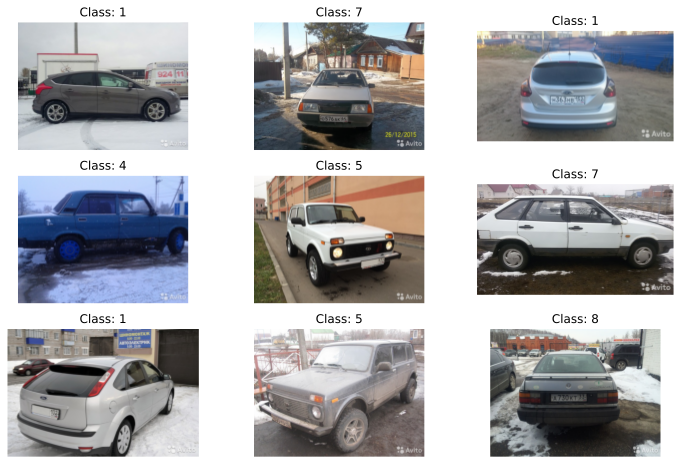

In [10]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

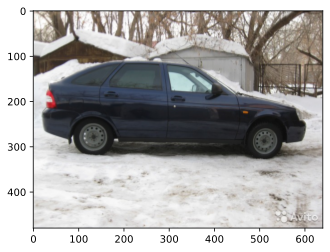

(640, 480)

In [13]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [13]:


train_datagen = ImageDataGenerator(
#     rescale=1. / 255, # EfficientNetB5 реализация от Keras подразумевает передачу картинок БЕЗ нормализации (RGB 8bit)
    rotation_range = 5,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range = 0.25,
    shear_range = 0.2,
    brightness_range=[0.3,1.3],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    dtype = np.int8,
    validation_split=VAL_SPLIT # set validation split
    )

test_datagen = ImageDataGenerator()

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

### Генерация данных

In [14]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 14009 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## Step 1 - Построение модели

### Загружаем предобученную сеть EfficientNetB5:

In [17]:
# чистите сессию иначе кончится память!
#s = reset_tf_session()
tf.keras.backend.clear_session()

In [18]:
def efficientnetb5():
    # предобученная сеть без последнего слоя (потому что у нас другие классы)
    model_ = EfficientNetB5(weights='../input/efficientnetb5-notop/efficientnetb5_notop.h5', include_top=False, input_shape=input_shape, drop_connect_rate=0.2)
    #model = EfficientNetB5(weights="imagenet", include_top=False, drop_connect_rate=0.3, input_shape=input_shape)
    #model_ = EfficientNetB5(weights="imagenet", include_top=False, input_shape=input_shape, drop_connect_rate=0.2)
    #model_ = EfficientNetB7(weights="imagenet", include_top=False, input_shape=input_shape, drop_connect_rate=0.2)
    #model_ = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)

    model_.trainable = False
    return model_

In [19]:
base_model = efficientnetb5()

In [20]:
base_model.summary()


Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [21]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = L.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = L.Dense(256, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=RANDOM_SEED))(x)
x = L.BatchNormalization(name='ADD_bn_1')(x)
x = L.Dropout(0.5)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = L.Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=LR), metrics=["accuracy"])

In [22]:
model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

__________________________________________________________________________________________________
block6a_se_reshape (Reshape)    (None, 1, 1, 1056)   0           block6a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6a_se_reduce (Conv2D)      (None, 1, 1, 44)     46508       block6a_se_reshape[0][0]         
__________________________________________________________________________________________________
block6a_se_expand (Conv2D)      (None, 1, 1, 1056)   47520       block6a_se_reduce[0][0]          
__________________________________________________________________________________________________
block6a_se_excite (Multiply)    (None, 7, 7, 1056)   0           block6a_activation[0][0]         
                                                                 block6a_se_expand[0][0]          
__________________________________________________________________________________________________
block6a_pr

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:

checkpoint =  C.ModelCheckpoint('best_model.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
earlystop = C.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = C.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=MIN_LR)

callbacks_list = [checkpoint]


In [ ]:
# history = model.fit_generator(
#         train_generator,
#         steps_per_epoch = len(train_generator),
#         validation_data = test_generator, 
#         validation_steps = len(test_generator),
#         epochs = EPOCHS,
#         callbacks = callbacks_list
# )

history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )
# Рекомендация: попробуйте применить transfer learning с fine-tuning

In [ ]:
draw_hist(history)

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5') #PATH
model.load_weights('best_model.hdf5')

**По всей видимости, модель работает неплохо.  
Попробуем добавить эпох обучения и поиграть с learning rate** 

-----------------------------------------  


In [ ]:
EPOCHS  = 10 #учим ещё
history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

In [ ]:
#model.load_weights('best_model.hdf5')

In [ ]:
callbacks_list[0].filepath = 'best_model_st3.hdf5'
EPOCHS  = 5  #учим ещё

history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

In [ ]:
callbacks_list[0].filepath = 'best_model_st4.hdf5'
EPOCHS               = 5  #учим ещё

history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
model.load_weights('best_model_st4.hdf5')
callbacks_list[0].filepath = 'best_model_st5.hdf5'
EPOCHS  = 5  #учим ещё

history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

In [ ]:
model.load_weights('best_model_st5.hdf5')
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

draw_hist(history)

97/97 [==============================] - 30s 313ms/step - loss: 0.9128 - accuracy: 0.6804  
Accuracy: 68.04%  

In [ ]:
callbacks_list[0].filepath = 'best_model_st6.hdf5'
LR                   = 1e-5

EPOCHS               = 5  #учим ещё

K.set_value(model.optimizer.learning_rate, LR)
history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

In [ ]:
model.load_weights('best_model_st6.hdf5')
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

После 50  эпох  получаем FixEfficientNet-B5 Accuracy: 69.27%, что сравнимо с Accuracy: 70.15% FixEfficientNet-B7  
  
97/97 [==============================] - 30s 312ms/step - loss: 0.8947 - accuracy: 0.6927  
Accuracy: 69.27%  

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Step 2 - FineTuning - обучение половины весов EfficientNetb5**

<h2 id="tips-for-fine-tuning-efficientnet">Tips for fine tuning EfficientNet</h2>
<p>On unfreezing layers:</p>
<ul>
<li>The <code>BathcNormalization</code> layers need to be kept frozen
(<a href="https://keras.io/guides/transfer_learning/">more details</a>).
If they are also turned to trainable, the
first epoch after unfreezing will significantly reduce accuracy.</li>
<li>In some cases it may be beneficial to open up only a portion of layers instead of
unfreezing all. This will make fine tuning much faster when going to larger models like
B7.</li>
<li>Each block needs to be all turned on or off. This is because the architecture includes
a shortcut from the first layer to the last layer for each block. Not respecting blocks
also significantly harms the final performance.</li>
</ul>
<p>Some other tips for utilizing EfficientNet:</p>
<ul>
<li>Larger variants of EfficientNet do not guarantee improved performance, especially for
tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet
chosen, the harder it is to tune hyperparameters.</li>
<li>EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch,
but not so much for transfer learning.</li>
<li>Do not use the RMSprop setup as in the original paper for transfer learning. The
momentum and learning rate are too high for transfer learning. It will easily corrupt the
pretrained weight and blow up the loss. A quick check is to see if loss (as categorical
cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same
epoch. If so, the initial learning rate/momentum is too high.</li>
<li>Smaller batch size benefit validation accuracy, possibly due to effectively providing
regularization.</li>
</ul>

In [23]:
# чистите сессию иначе кончится память!
tf.keras.backend.clear_session()

In [24]:
# Когда опять кончится время - восстановимся из этой точки :)
model.load_weights('../input/best-model-st6-6927hdf5/best_model_st6_69.27.hdf5')

In [25]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [26]:
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4#1e-4
MIN_LR               = 1e-5
VAL_SPLIT            = 0.1 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [27]:
'''
A side note on freezing/unfreezing models:
setting trainable of a Model will simultaneously set all layers belonging to the Model to the same trainable attribute.
Each layer is trainable only if both the layer itself and the model containing it are trainable.
Hence when we need to partially freeze/unfreeze a model, we need to make sure the trainable attribute of the model is set to True.
'''

model.trainable = True

# Fine-tune from this layer onwards
# !!!Each block needs to be all turned on or off!!! 
# https://www.iditect.com/how-to/50151157.html
split_layer_name = 'block5a_expand_conv'
layer_names = [layer.name for layer in model.layers]
fine_tune_at = layer_names.index(split_layer_name) - 5 #-1
print(f'start from layer {model.layers[-fine_tune_at].name}, index {fine_tune_at}')
#fine_tune_at = len(model.layers)//2 #50%

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers:
    layer.trainable =  False


# We unfreeze the top fine_tune_at layers while leaving BatchNorm layers frozen
for layer in model.layers[-fine_tune_at:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=LR), metrics=["accuracy"])

start from layer block5a_expand_conv, index 288


In [28]:
checkpoint =  C.ModelCheckpoint('best_model_50perc_st1.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
earlystop = C.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = C.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=MIN_LR)

callbacks_list = [checkpoint]

In [29]:
history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

Epoch 1/10
876/876 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7711
Epoch 00001: val_accuracy improved from -inf to 0.85438, saving model to best_model_50perc_st1.hdf5
876/876 [==============================] - 315s 360ms/step - loss: 0.6496 - accuracy: 0.7711 - val_loss: 0.4188 - val_accuracy: 0.8544
Epoch 2/10
876/876 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8753
Epoch 00002: val_accuracy improved from 0.85438 to 0.90013, saving model to best_model_50perc_st1.hdf5
876/876 [==============================] - 319s 364ms/step - loss: 0.3562 - accuracy: 0.8753 - val_loss: 0.3034 - val_accuracy: 0.9001
Epoch 3/10
876/876 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9105
Epoch 00003: val_accuracy improved from 0.90013 to 0.92590, saving model to best_model_50perc_st1.hdf5
876/876 [==============================] - 314s 359ms/step - loss: 0.2517 - accuracy: 0.9105 - val_loss: 0.2438 - val_accuracy: 0.9259
E

97/97 [==============================] - 29s 303ms/step - loss: 0.2108 - accuracy: 0.9349
Accuracy: 93.49%


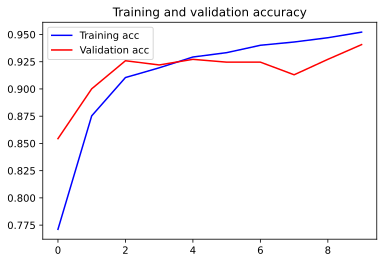

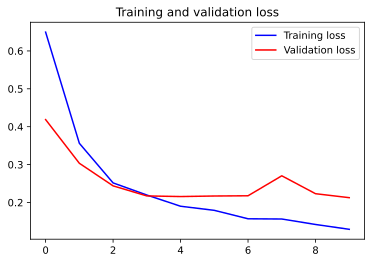

In [33]:
model.load_weights('./best_model_50perc_st1.hdf5')
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
draw_hist(history)

### **Уменьшим Learning Rate до 1e-5 и дообучим 3 эпохи**

In [34]:
LR                   = 1e-5
MIN_LR               = 1e-6
EPOCHS               = 3  #учим ещё
BATCH_SIZE           = 16

checkpoint =  C.ModelCheckpoint('best_model_50perc_st2.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
earlystop = C.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = C.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=MIN_LR)

callbacks_list = [checkpoint]

K.set_value(model.optimizer.learning_rate, LR)
history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

Epoch 1/3
876/876 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9691
Epoch 00001: val_accuracy improved from -inf to 0.94716, saving model to best_model_50perc_st2.hdf5
876/876 [==============================] - 304s 347ms/step - loss: 0.0777 - accuracy: 0.9691 - val_loss: 0.1613 - val_accuracy: 0.9472
Epoch 2/3
876/876 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9727
Epoch 00002: val_accuracy did not improve from 0.94716
876/876 [==============================] - 312s 356ms/step - loss: 0.0639 - accuracy: 0.9727 - val_loss: 0.1738 - val_accuracy: 0.9433
Epoch 3/3
876/876 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9744
Epoch 00003: val_accuracy did not improve from 0.94716
876/876 [==============================] - 313s 357ms/step - loss: 0.0641 - accuracy: 0.9744 - val_loss: 0.1749 - val_accuracy: 0.9452


In [41]:
model.load_weights('./best_model_50perc_st2.hdf5')
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

97/97 [==============================] - 30s 311ms/step - loss: 0.1739 - accuracy: 0.9433
Accuracy: 94.33%


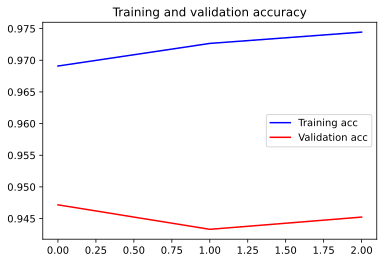

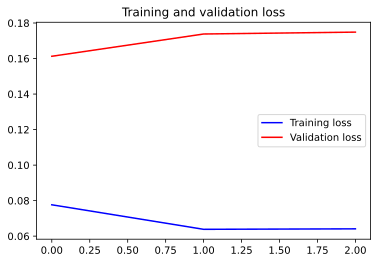

In [42]:
draw_hist(history)

### **Уменьшим Learning Rate до 1e-6 и дообучим 5 эпох**

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


## **Step 3 - FineTuning - обучение ВСЕХ весов EfficientNetb5, кроме BatchNormalization**


In [45]:
model.load_weights('./best_model_50perc_st2.hdf5')

In [46]:
model.trainable = True

# Fine-tune from this layer onwards


# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers:
    layer.trainable =  False


# We unfreeze all layers while leaving BatchNorm layers frozen
for layer in model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=LR), metrics=["accuracy"])

Epoch 1/5
876/876 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9729
Epoch 00001: val_accuracy improved from -inf to 0.94910, saving model to best_model_100perc_st1.hdf5
876/876 [==============================] - 428s 488ms/step - loss: 0.0712 - accuracy: 0.9729 - val_loss: 0.1664 - val_accuracy: 0.9491
Epoch 2/5
876/876 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9751
Epoch 00002: val_accuracy did not improve from 0.94910
876/876 [==============================] - 422s 482ms/step - loss: 0.0600 - accuracy: 0.9751 - val_loss: 0.1602 - val_accuracy: 0.9465
Epoch 3/5
876/876 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9744
Epoch 00003: val_accuracy did not improve from 0.94910
876/876 [==============================] - 428s 489ms/step - loss: 0.0617 - accuracy: 0.9744 - val_loss: 0.1485 - val_accuracy: 0.9491
Epoch 4/5
876/876 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9718
Epoc

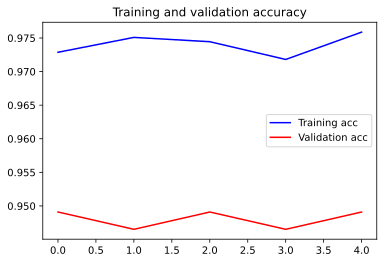

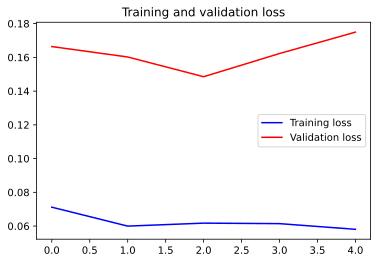

In [47]:
LR                   = 1e-6
MIN_LR               = 1e-7
EPOCHS               = 5  
BATCH_SIZE           = 6

checkpoint =  C.ModelCheckpoint('best_model_100perc_st1.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
earlystop = C.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = C.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=MIN_LR)

callbacks_list = [checkpoint]

K.set_value(model.optimizer.learning_rate, LR)
history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

model.load_weights('./best_model_100perc_st1.hdf5')
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
draw_hist(history)

### ДОобучение 100% сети практически НЕ дает результата  
In some cases it may be beneficial to open up only a portion of layers instead of unfreezing all. This will make fine tuning much faster when going to larger models like B7.

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## Step 4 - увеличим размер изображения до 456dpi - исходного разрешения для EfficientNetB5

In [31]:
EPOCHS               = 15  # эпох на обучение
BATCH_SIZE           = 4 # уменьшаем batch для улучшения сходимости на validation
LR                   = 1e-5#1e-4

VAL_SPLIT            = 0.1 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 456 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [32]:
train_datagen_simple = ImageDataGenerator(
#     zoom_range=[0.75,1.25],
#     horizontal_flip=True,
#     vertical_flip=False,
#     fill_mode='nearest',
#     dtype = np.int8,
    ###
    rotation_range = 5,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range = 0.25,
    shear_range = 0.2,
    brightness_range=[0.3,1.3],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    dtype = np.int8,
    ###
    validation_split=VAL_SPLIT # set validation split
    )


train_generator_simple = train_datagen_simple.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator_simple = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 14009 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.


In [33]:
#base_model = EfficientNetB5(weights='./best_model_100perc_st1.hdf5', include_top=False, input_shape=input_shape, drop_connect_rate=0.2)
base_model = EfficientNetB5(weights='../input/efficientnetb5-notop/efficientnetb5_notop.h5', include_top=False, input_shape=input_shape, drop_connect_rate=0.2)


In [34]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = L.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = L.Dense(256, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=RANDOM_SEED))(x)
x = L.BatchNormalization(name='ADD_bn_1')(x)
x = L.Dropout(0.5)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = L.Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)

model.trainable = True

# Fine-tune from this layer onwards


# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers:
    layer.trainable =  False


# We unfreeze all layers while leaving BatchNorm layers frozen
for layer in model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

        
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=LR), metrics=["accuracy"])

model.load_weights('../input/best-model-50perc-st2hdf5/best_model_50perc_st2.hdf5') #НЕ берем веса 100 обученной модели - она не дает улучшения

In [35]:
checkpoint =  C.ModelCheckpoint('best_model_456.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
earlystop = C.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks_list = [checkpoint]

K.set_value(model.optimizer.learning_rate, LR)
history = model.fit(
    train_generator_simple,
    validation_data = test_generator_simple,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose=1,
    max_queue_size=30, workers=20, use_multiprocessing=False
    )

Epoch 1/15
3503/3503 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9674
Epoch 00001: val_accuracy improved from -inf to 0.96456, saving model to best_model_456.hdf5
3503/3503 [==============================] - 1797s 513ms/step - loss: 0.0833 - accuracy: 0.9674 - val_loss: 0.1244 - val_accuracy: 0.9646
Epoch 2/15
3503/3503 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9736
Epoch 00002: val_accuracy did not improve from 0.96456
3503/3503 [==============================] - 1774s 506ms/step - loss: 0.0672 - accuracy: 0.9736 - val_loss: 0.1275 - val_accuracy: 0.9607
Epoch 3/15
3503/3503 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9774
Epoch 00003: val_accuracy did not improve from 0.96456
3503/3503 [==============================] - 1783s 509ms/step - loss: 0.0548 - accuracy: 0.9774 - val_loss: 0.1216 - val_accuracy: 0.9601
Epoch 4/15
3503/3503 [==============================] - ETA: 0s - loss: 0.0487 - accuracy

KeyboardInterrupt: 

### Модель не обучается и эпоха длится слишком долго, чтоб дождаться остановки автоматической. Останавливаем обучение вручную.

In [38]:
model.load_weights('./best_model_456.hdf5')
scores = model.evaluate_generator(test_generator_simple, steps=len(test_generator_simple), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
#draw_hist(history)

388/388 [==============================] - 89s 228ms/step - loss: 0.1254 - accuracy: 0.9639
Accuracy: 96.39%


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Предсказание на тестовых данных

In [32]:
IMG_SIZE             = 456 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [34]:
fin_model = keras.models.load_model('../input/best-model-456hdf5/best_model_456.hdf5') # best_model_456 чуть точнее

In [35]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [37]:
test_sub_generator.samples

6675

In [38]:
test_sub_generator.reset()
predictions = fin_model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

418/418 [==============================] - 42s 100ms/step


In [39]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_no_TTA.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [40]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,7


### Test Time Augmentation

In [28]:
fin_model = keras.models.load_model('../input/best-model-456hdf5/best_model_456.hdf5')

In [29]:
train_datagen = ImageDataGenerator(
#     rescale=1. / 255, # EfficientNetB5 реализация от Keras подразумевает передачу картинок БЕЗ нормализации (RGB 8bit)
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range = 0.25,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    dtype = np.int8,
    validation_split=VAL_SPLIT # set validation split
    )


In [30]:
IMG_SIZE             = 456 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

test_sub_generator_TTA = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

test_sub_generator_TTA.reset()

tta_steps = 5 # берем среднее из 5 предсказаний
predictions = []

for i in range(tta_steps):
    preds = fin_model.predict_generator(test_sub_generator_TTA, steps=len(test_sub_generator_TTA), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

filenames_with_dir=test_sub_generator_TTA.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Found 6675 validated image filenames.
418/418 [==============================] - 366s 875ms/step
Save submit


In [31]:
submission.head()

,Id,Category
0,305108.jpg,2
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


### TTA не дает улучшения. 

***********************************************************************

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

*************************************************************************

# Выводы

## В проекте были применены следующие техники:
* В качестве базовой архитектуры выбрана EfficientNet B5. Выбор был в надежде, что заметно меньший размер (2.5 раза по сравнению с B7)\  
  сети при несколько меньшей точности (~1.5%) даст возможность работать на большем разрешении\  
  и применять модель на мобильных устройствах средней производительности. 
* В качестве весов инициализации базовой модели были выбраны предобученные по технологии "Noisy student" веса.
* Была выбрана реализация EfficientNetB5 из Keras\
  Особенностью данной реализации является подача в модель RGB 8bit изображений - нормализация проводится в самой модели.
* Применялся transfer learning с "новой головой" достаточно простой структуры. В качестве регуляризации использовались BatchNormalization и сильный Dropout(0.5)
* Применялся fine-tuning с заморозкой примерно половины нижних (начальных) уровней сети,    
  при этом BatchNormalization уровни в "размороженной" части оставались замороженными, что давало большую скорость обучения.    
  Обучение 100% сети не дало результата. Это поведение было описано в документации. 
* Применялись различные LR на разных шагах - чем этап глубже, тем ниже LR
* optimizer ADAM показал лучшую сходимость, RMSprop не рекомендуется использовать при fine-tuning EfficientNet
* loss categorical_crossentropy
* Pазмер изображения должен быть кратен 8 и 16, использовались 2 разрешения: 224dpi и 456dpi.  
    Transfer learning и основной fine-tuning проводились на разрешении 224dpi     
    Последний шаг дообучения на разрешении 456dpi (4 эпохи)
* Размер батча уменьшался с каждым шагом, что давало лучшую сходимость на тестовых данных (хотя памяти GPU было достаточно)
* Применялись функции callback ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  
* Применение TTA (Test Time Augmentation) не дало прироста точности
* Возможностей Keras по аугментации было достаточно.  
  Подбор более продвинутх библиотек аугментации изображений слишком долог по времени (жалко тратить 40 часов лимита GPU)   
  и на представленных изображениях врядли даст прирост.  
  Возможно, из продвинутых техник было бы полезно применить [CLAHE (Contrast Limited Adaptive Histogram Equalization)](https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html) и  
  [Адаптивную гамма коррекцию](https://jivp-eurasipjournals.springeropen.com/articles/10.1186/s13640-016-0138-1)  
  Применение данных алгоритмов в обработке фотографий для последующей печати дает отличный результат. Должно и здесь сработать.  
  К сожалению, для экспериментов не хватило времени GPU.
  

# Выводы:
* Выбор в качестве базовой архитектуры выбрана EfficientNet B5 был оправдан:
    Модель настроенная на разрешение 456dpi дала результат 0.97213 при лучшем результате на leaderboard 0.98292 :)
    Размер файла модели (456dpi) 340Mb - что НЕ сравнимо с B7 НО при 224dpi (741.53Mb)   
    что дает возможность при несколько меньшей точности (~1.0%) на большем разрешении (разница в детализации 224dpi vs 456dpi огромна) и downsapling в меньшее разрешение - процесс с сильными потерями информации, к тому же не быстрый.    
    а так же применять модель на мобильных устройствах средней производительности. 
* Были получены и закреплены практические + теоретические навыки
* Попытка сначала провести transfer learning + fine-tuning на Stanford Cars Dataset, а затем использовать полученную модель в соревновании  - требует дальнейшей проработки..   
      Видимо сказывается большое количество классов (196) и малый размер датасета (~8000 изображений).    
      Попробую сгруппировать изображения для получения меньшего к-ва классов (например все Audi/BMW/...)    
      Требуется провести доп. аугментацию. Обкропить картинки по данным из датасета (увеличиваем к-во изображений в 2-а раза)  
      UPD. Данные действия привели к положительному результату. Классификатор обучился до val_accuracy: 0.5206.    
      Уже видно, что можно не учить дальше классификатор, а fine-tune-ить модель, и затем её использовать как базу.    
      